In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [27]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
import time

In [28]:
from torchvision.models import resnet50, ResNet50_Weights

In [ ]:
from numpy.core.fromnumeric import shape
def load_data(path,batch_size,input_size):
    
    normalize = transforms.Compose([
        transforms.Resize((input_size,input_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ]) 
    transform_dict = {"src":  normalize}  
    data = datasets.ImageFolder(root=path,transform=transform_dict["src"])
    train_size=int(0.75*len(data))
    test_size=int(len(data)-train_size)
    train, test = td.random_split(data,[train_size,test_size])

    data_loader_train = td.DataLoader(train,batch_size=batch_size,shuffle=True,drop_last=False,num_workers=0)
    data_loader_test = td.DataLoader(test,batch_size=batch_size,shuffle=True,drop_last=False,num_workers=0)
    # data_loader_val = td.DataLoader(val,batch_size=batch_size,shuffle=True,drop_last=False,num_workers=0)
    return data_loader_train, data_loader_test

In [ ]:
data_loader_train,data_loader_test=load_data(r"/content/gdrive/MyDrive/Colab Notebooks/images",32,64)

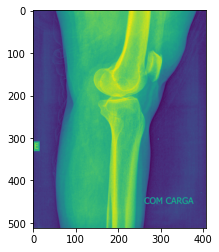

In [ ]:
img2=image.imread(r"/content/gdrive/MyDrive/Colab Notebooks/images/train/1.2.826.0.1.3680043.8.498.10299385524344582994601970314833752000-c.png")
plt.imshow(img2)

In [ ]:
import torch.optim as optim
from torchvision.models import resnet50
net=resnet50(weights=None)
resnet50(pretrained=False) 
# net = resNet50(22).to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

In [ ]:
###### Define and run your training loop here #########
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
net.to(device)

num_epochs = 5
total_steps = len(data_loader_train)
t1 = time.time()
for epoch in range(num_epochs):
    for i, data in enumerate(data_loader_train):
        images, labels = data[0].to(device), data[1].to(device)
        # Forward pass
        outputs = net(images)
        loss = criterion(outputs, labels)
        # print("kjnfjnrnkrn",i)
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print("second time",i)
        # Train accuracy
        total = labels.size(0)
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        if (i + 1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(),
                    (correct / total) * 100))
            
print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

Device: cpu
Epoch [1/5], Step [10/59], Loss: 2.3850, Accuracy: 78.12%
Epoch [1/5], Step [20/59], Loss: 1.2241, Accuracy: 59.38%
Epoch [1/5], Step [30/59], Loss: 1.8839, Accuracy: 50.00%
Epoch [1/5], Step [40/59], Loss: 2.2764, Accuracy: 75.00%
Epoch [1/5], Step [50/59], Loss: 3.0181, Accuracy: 68.75%
Epoch [2/5], Step [10/59], Loss: 1.2731, Accuracy: 21.88%
Epoch [2/5], Step [20/59], Loss: 0.8800, Accuracy: 84.38%
Epoch [2/5], Step [30/59], Loss: 1.2895, Accuracy: 59.38%
Epoch [2/5], Step [40/59], Loss: 1.1206, Accuracy: 65.62%
Epoch [2/5], Step [50/59], Loss: 0.8618, Accuracy: 81.25%
Epoch [3/5], Step [10/59], Loss: 1.0854, Accuracy: 71.88%
Epoch [3/5], Step [20/59], Loss: 1.1108, Accuracy: 68.75%
Epoch [3/5], Step [30/59], Loss: 1.1042, Accuracy: 71.88%
Epoch [3/5], Step [40/59], Loss: 1.0185, Accuracy: 68.75%
Epoch [3/5], Step [50/59], Loss: 1.1099, Accuracy: 68.75%
Epoch [4/5], Step [10/59], Loss: 1.1666, Accuracy: 59.38%
Epoch [4/5], Step [20/59], Loss: 1.0177, Accuracy: 68.75%
Ep

In [ ]:
net.eval() 
perds = []
target = []
with torch.no_grad(): 
    correct = 0
    total = 0
    for data in data_loader_test:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        perds.extend(predicted)
        target.extend(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {} %'
        .format(total, (correct / total) * 100))
    

Test Accuracy of the model on the 621 test images: 71.98067632850241 %


In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 5.0 MB/s 


In [ ]:
from torchmetrics.functional import precision_recall
from torchmetrics import F1Score
from torchmetrics import ConfusionMatrix
perds1 = torch.stack(perds)
target1 = torch.stack(target)
f1 = F1Score(num_classes=22).to(device)
print(f1(perds1, target1))
print(precision_recall(perds1, target1, average='macro', num_classes=22))
confmat = ConfusionMatrix(num_classes=22).to(device)
confmat(perds1, target1)

tensor(0.7198)
(tensor(0.3599), tensor(0.5000))


tensor([[  0, 174,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0],
        [  0, 447,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,

In [29]:
!pip -q install torchxrayvision

In [30]:
import torchxrayvision as xrv

In [31]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset

fatal: destination path 'covid-chestxray-dataset' already exists and is not an empty directory.


In [32]:
d = xrv.datasets.COVID19_Dataset(imgpath="covid-chestxray-dataset/images/",csvpath="covid-chestxray-dataset/metadata.csv")

In [33]:
import matplotlib.pyplot as plt

In [36]:
sample = d[18]

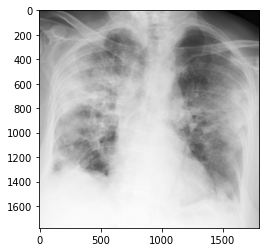

In [37]:
plt.imshow(sample["img"][0], cmap="gray");

In [38]:
# full details about the image is available in the pandas csv
d.csv.iloc[0]

index                                                                     0
patientid                                                                 2
offset                                                                  0.0
sex                                                                       M
age                                                                    65.0
finding                                            Pneumonia/Viral/COVID-19
RT_PCR_positive                                                           Y
survival                                                                  Y
intubated                                                                 N
intubation_present                                                        N
went_icu                                                                  N
in_icu                                                                    N
needed_supplemental_O2                                                    Y
extubated   

In [39]:
import pandas as pd
pd.Series(dict(zip(d.pathologies,sample["lab"])))

Aspergillosis     0.0
Aspiration        0.0
Bacterial         0.0
COVID-19          0.0
Chlamydophila     0.0
Fungal            0.0
H1N1              0.0
Herpes            0.0
Influenza         0.0
Klebsiella        0.0
Legionella        0.0
Lipoid            0.0
MERS-CoV          0.0
MRSA              0.0
Mycoplasma        0.0
No Finding        0.0
Nocardia          0.0
Pneumocystis      0.0
Pneumonia         1.0
SARS              1.0
Staphylococcus    0.0
Streptococcus     0.0
Tuberculosis      0.0
Varicella         0.0
Viral             1.0
dtype: float32

In [40]:
d.pathologies,sample["lab"]

(['Aspergillosis',
  'Aspiration',
  'Bacterial',
  'COVID-19',
  'Chlamydophila',
  'Fungal',
  'H1N1',
  'Herpes ',
  'Influenza',
  'Klebsiella',
  'Legionella',
  'Lipoid',
  'MERS-CoV',
  'MRSA',
  'Mycoplasma',
  'No Finding',
  'Nocardia',
  'Pneumocystis',
  'Pneumonia',
  'SARS',
  'Staphylococcus',
  'Streptococcus',
  'Tuberculosis',
  'Varicella',
  'Viral'],
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 0., 0., 1.], dtype=float32))

In [41]:
import torch
import cv2
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image

In [42]:
import skimage, torch, torchvision

import torch
from torch import Tensor
from torch import nn
from random import shuffle
import cv2
from google.colab.patches import cv2_imshow
import torchvision
import pandas as pd                     

import os
import time
from torch import optim
import torch
from torch import nn
from torch import optim
from torch.cuda import amp
from torch.optim import lr_scheduler
from torch.optim.swa_utils import AveragedModel
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, models, transforms

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot


In [43]:
class ImageDataset(Dataset):
    def __init__(self, csv, train, test):
        self.csv = csv
        self.train = train
        self.test = test
        self.csv = self.csv.drop_duplicates(subset=['filename'])
        self.all_image_names = self.csv[:]['filename']
        self.all_labels = np.array(['Aspergillosis', 'Aspiration', 'Bacterial', 'COVID-19', 'Chlamydophila' , 'Fungal', 'H1N1', 'Herpes', 'Influenza', 'Klebsiella', 'Legionella', 'Lipoid', 'MERS-CoV', 'MRSA', 'Mycoplasma', 'No Finding', 'Nocardia', 'Pneumocystis', 'Pneumonia', 'SARS', 'Staphylococcus', 'Streptococcus', 'Tuberculosis', 'Varicella', 'Viral'])
        self.df = np.array(self.csv[['filename','finding']])
        self.train_ratio = int(0.85 * len(self.csv))
        self.valid_ratio = len(self.csv) - self.train_ratio
        dictlables = {'Aspergillosis': 1, 
        'Aspiration':  2 , 
        'Bacterial':   3, 
        'COVID-19':  4, 
        'Chlamydophila': 5, 
        'Fungal' :   6, 
        'H1N1' :   7, 
        'Herpes ' :   8, 
        'Influenza' :   9 , 
        'Klebsiella' :   10, 
        'Legionella' :   11, 
        'Lipoid' :   12 , 
        'MERS-CoV'  : 13, 
        'MRSA' :   14, 
        'Mycoplasma' :   15, 
        'No Finding' :  16, 
        'Nocardia' :   17, 
        'Pneumocystis' :   18, 
        'Pneumonia' :   19, 
        'SARS' :   20, 
        'Staphylococcus' : 21, 
        'Streptococcus' :   22, 
        'Tuberculosis' :   23, 
        'Varicella' :   24, 
        'Viral' : 25,
        'E.Coli':26, 
        'Unknown': 16,
        'todo':16,
         } 
        # set the training data images and labels
        self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((227, 227)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

            ])
        if self.train == True:
            print(f"Number of training images: {self.train_ratio}")
            self.image_names = list(self.all_image_names[:self.train_ratio])

            self.labels = list(self.df[:self.train_ratio][:,1])
            self.labels = list(np.char.split(self.labels,sep ='/'))
            for idx,x in enumerate(self.labels):
              if len(x) == 0:
                x = ['Unknown']
              for i in range(3 - len(x)):
                x.append('Unknown')
              
              for idy,y in enumerate(x):
                self.labels[idx][idy] = dictlables[y]
              
              self.labels[idx] = self.labels[idx][0:3]
              
                
            print(self.labels)
        # set the validation data images and labels
        elif self.train == False and self.test == False:
            print(f"Number of validation images: {self.valid_ratio}")
            self.image_names = list(self.all_image_names[-self.valid_ratio:-10])
            self.labels = list(self.df[-self.valid_ratio:][:,1])
            self.labels = list(np.char.split(self.labels,sep ='/'))


            for idx,x in enumerate(self.labels):
              if len(x) == 0:
                x = ['Unknown']
              for i in range(3 - len(x)):
                x.append('Unknown')
              
              for idy,y in enumerate(x):
                self.labels[idx][idy] = dictlables[y]
              
              self.labels[idx] = self.labels[idx][0:3]
              
                
            print(self.labels)
           
        # set the test data images and labels, only last 10 images
        # this, we will use in a separate inference script
        elif self.test == True and self.train == False:
            self.image_names = list(self.all_image_names[-10:][:,1])
            self.labels = list(np.char.split(self.labels,sep ='/'))
            for idx,x in enumerate(self.labels):
              if len(x) == 0:
                x = ['Unknown']
              for i in range(3 - len(x)):
                x.append('Unknown')
              
              for idy,y in enumerate(x):
                self.labels[idx][idy] = dictlables[y]
              
              self.labels[idx] = self.labels[idx][0:3]
              
                
            print(self.labels)
             # define the test transforms
            
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        image = cv2.imread("./covid-chestxray-dataset/images/"+self.image_names[index])
        # convert the image from BGR to RGB color format
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply image transforms
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform(image)
        
        targets = self.labels[index]

        return {
            'image': torch.tensor(image, dtype=torch.float32),
            'label': torch.tensor(targets, dtype=torch.float32)
        }

In [44]:
train_csv = pd.read_csv('./covid-chestxray-dataset/metadata.csv')
train_csv = train_csv[train_csv['filename'].str.contains(".nii.gz") == False]
batch_size = 32
# train dataset
train_data = ImageDataset(
    train_csv, train=True, test=False
)
train_data.all_image_names[10]
# validation dataset
valid_data = ImageDataset(
    train_csv, train=False, test=False
)
# train data loader
train_loader = DataLoader(
    train_data, 
    batch_size=batch_size,
    shuffle=True
)
# validation data loader
valid_loader = DataLoader(
    valid_data, 
    batch_size=batch_size,
    shuffle=False
)

Number of training images: 789
[[19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 16, 16], [19, 25, 4], [19, 25, 4], [19, 25, 20], [19, 25, 20], [19, 25, 20], [19, 25, 20], [19, 25, 20], [19, 25, 20], [19, 25, 20], [19, 25, 20], [19, 25, 20], [19, 25, 20], [19, 25, 20], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 16, 16], [19, 16, 16], [19, 16, 16], [19, 6, 18], [19, 6, 18], [19, 3, 22], [19, 3, 22], [19, 3, 22], [19, 3, 22], [19, 3, 22], [19, 3, 22], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19, 25, 4], [19,

In [45]:
import torch.optim as optim
from torchvision.models import resnet50
model=resnet50(pretrained=False)
resnet50(weights=None) 

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model.to(device)
epochs = 50


In [47]:
import torch
import cv2
from tqdm import tqdm

Accuracies = []
total_steps = len(train_data)
# training function
model.to(device)
counter = 0
for epoch in range(epochs):
    print('Training')
    model.train()
    
    train_running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        counter += 1
        data, target = data['image'].to(device), data['label'].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        # apply sigmoid activation to get all the outputs between 0 and 1
        outputs = torch.sigmoid(outputs)
        outputs = outputs.narrow(1,0,3)
        outputs = outputs.narrow(0,0,target.size(dim=0))
        loss = criterion(target,outputs)
        train_running_loss += loss.item()
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()
        
        total = target.size(0)
        _,predicted = torch.max(outputs.data, 1)
        predicted = predicted.narrow(0,0,3)
        correct = (predicted == target).sum().item()
        if (i + 1) % 5 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch + 1, epochs, i + 1, total_steps, loss.item(),
                    (correct / total) * 100))
            Accuracies.append((correct / total) * 100)

    train_loss = train_running_loss / counter
    print(train_loss)

Training


 21%|██        | 5/24 [00:07<00:30,  1.62s/it]

Epoch [1/50], Step [5/789], Loss: 0.2545, Accuracy: 67.05%


 42%|████▏     | 10/24 [00:15<00:23,  1.67s/it]

Epoch [1/50], Step [10/789], Loss: 0.1428, Accuracy: 78.22%


 62%|██████▎   | 15/24 [00:24<00:13,  1.53s/it]

Epoch [1/50], Step [15/789], Loss: 0.2491, Accuracy: 67.59%


 83%|████████▎ | 20/24 [00:32<00:06,  1.63s/it]

Epoch [1/50], Step [20/789], Loss: 0.2471, Accuracy: 67.79%


25it [00:39,  1.59s/it]


Epoch [1/50], Step [25/789], Loss: 0.1741, Accuracy: 75.09%
0.014793967194855213
Training


 21%|██        | 5/24 [00:08<00:35,  1.88s/it]

Epoch [2/50], Step [5/789], Loss: 0.1762, Accuracy: 74.88%


 42%|████▏     | 10/24 [00:16<00:22,  1.59s/it]

Epoch [2/50], Step [10/789], Loss: 0.2935, Accuracy: 63.15%


 62%|██████▎   | 15/24 [00:26<00:17,  1.95s/it]

Epoch [2/50], Step [15/789], Loss: 0.1061, Accuracy: 81.89%


 83%|████████▎ | 20/24 [00:35<00:06,  1.68s/it]

Epoch [2/50], Step [20/789], Loss: 0.2479, Accuracy: 67.71%


25it [00:42,  1.69s/it]


Epoch [2/50], Step [25/789], Loss: 0.1622, Accuracy: 76.28%
0.006317887008190155
Training


 21%|██        | 5/24 [00:08<00:30,  1.58s/it]

Epoch [3/50], Step [5/789], Loss: 0.2546, Accuracy: 67.04%


 42%|████▏     | 10/24 [00:17<00:25,  1.84s/it]

Epoch [3/50], Step [10/789], Loss: 0.1457, Accuracy: 77.93%


 62%|██████▎   | 15/24 [00:26<00:15,  1.67s/it]

Epoch [3/50], Step [15/789], Loss: 0.2908, Accuracy: 63.42%


 83%|████████▎ | 20/24 [00:34<00:06,  1.73s/it]

Epoch [3/50], Step [20/789], Loss: 0.2646, Accuracy: 66.04%


25it [00:41,  1.67s/it]


Epoch [3/50], Step [25/789], Loss: 0.2743, Accuracy: 65.07%
0.0037416026989618937
Training


 21%|██        | 5/24 [00:07<00:32,  1.70s/it]

Epoch [4/50], Step [5/789], Loss: 0.2700, Accuracy: 65.50%


 42%|████▏     | 10/24 [00:16<00:23,  1.69s/it]

Epoch [4/50], Step [10/789], Loss: 0.1556, Accuracy: 76.94%


 62%|██████▎   | 15/24 [00:24<00:14,  1.62s/it]

Epoch [4/50], Step [15/789], Loss: 0.1295, Accuracy: 79.55%


 83%|████████▎ | 20/24 [00:31<00:06,  1.55s/it]

Epoch [4/50], Step [20/789], Loss: 0.2865, Accuracy: 63.85%


25it [00:39,  1.60s/it]


Epoch [4/50], Step [25/789], Loss: 0.2608, Accuracy: 66.42%
0.0025353416986763477
Training


 21%|██        | 5/24 [00:07<00:33,  1.74s/it]

Epoch [5/50], Step [5/789], Loss: 0.1174, Accuracy: 80.76%


 42%|████▏     | 10/24 [00:16<00:21,  1.53s/it]

Epoch [5/50], Step [10/789], Loss: 0.1426, Accuracy: 78.24%


 62%|██████▎   | 15/24 [00:24<00:15,  1.72s/it]

Epoch [5/50], Step [15/789], Loss: 0.1986, Accuracy: 72.64%


 83%|████████▎ | 20/24 [00:33<00:06,  1.65s/it]

Epoch [5/50], Step [20/789], Loss: 0.2942, Accuracy: 63.08%


25it [00:41,  1.65s/it]


Epoch [5/50], Step [25/789], Loss: 0.1102, Accuracy: 81.48%
0.0019038084484636784
Training


 21%|██        | 5/24 [00:08<00:32,  1.71s/it]

Epoch [6/50], Step [5/789], Loss: 0.2243, Accuracy: 70.07%


 42%|████▏     | 10/24 [00:16<00:21,  1.55s/it]

Epoch [6/50], Step [10/789], Loss: 0.2077, Accuracy: 71.73%


 62%|██████▎   | 15/24 [00:24<00:14,  1.67s/it]

Epoch [6/50], Step [15/789], Loss: 0.1876, Accuracy: 73.74%


 83%|████████▎ | 20/24 [00:32<00:06,  1.66s/it]

Epoch [6/50], Step [20/789], Loss: 0.1884, Accuracy: 73.66%


25it [00:39,  1.59s/it]


Epoch [6/50], Step [25/789], Loss: 0.1571, Accuracy: 76.79%
0.0014853538510700066
Training


 21%|██        | 5/24 [00:07<00:27,  1.46s/it]

Epoch [7/50], Step [5/789], Loss: 0.1121, Accuracy: 81.29%


 42%|████▏     | 10/24 [00:15<00:21,  1.53s/it]

Epoch [7/50], Step [10/789], Loss: 0.2597, Accuracy: 66.53%


 62%|██████▎   | 15/24 [00:22<00:14,  1.63s/it]

Epoch [7/50], Step [15/789], Loss: 0.2749, Accuracy: 65.01%


 83%|████████▎ | 20/24 [00:32<00:07,  1.91s/it]

Epoch [7/50], Step [20/789], Loss: 0.2771, Accuracy: 64.79%


25it [00:39,  1.59s/it]


Epoch [7/50], Step [25/789], Loss: 0.2151, Accuracy: 70.99%
0.0012085091908063208
Training


 21%|██        | 5/24 [00:07<00:30,  1.58s/it]

Epoch [8/50], Step [5/789], Loss: 0.1193, Accuracy: 80.57%


 42%|████▏     | 10/24 [00:15<00:23,  1.70s/it]

Epoch [8/50], Step [10/789], Loss: 0.1833, Accuracy: 74.17%


 62%|██████▎   | 15/24 [00:24<00:15,  1.72s/it]

Epoch [8/50], Step [15/789], Loss: 0.1693, Accuracy: 75.57%


 83%|████████▎ | 20/24 [00:32<00:06,  1.67s/it]

Epoch [8/50], Step [20/789], Loss: 0.2485, Accuracy: 67.65%


25it [00:39,  1.60s/it]


Epoch [8/50], Step [25/789], Loss: 0.1925, Accuracy: 73.25%
0.0010132070281542837
Training


 21%|██        | 5/24 [00:09<00:35,  1.84s/it]

Epoch [9/50], Step [5/789], Loss: 0.2282, Accuracy: 69.68%


 42%|████▏     | 10/24 [00:17<00:22,  1.58s/it]

Epoch [9/50], Step [10/789], Loss: 0.1141, Accuracy: 81.09%


 62%|██████▎   | 15/24 [00:25<00:13,  1.55s/it]

Epoch [9/50], Step [15/789], Loss: 0.1892, Accuracy: 73.58%


 83%|████████▎ | 20/24 [00:33<00:06,  1.59s/it]

Epoch [9/50], Step [20/789], Loss: 0.1673, Accuracy: 75.77%


25it [00:40,  1.63s/it]


Epoch [9/50], Step [25/789], Loss: 0.2023, Accuracy: 72.27%
0.0008741589801179038
Training


 21%|██        | 5/24 [00:08<00:31,  1.64s/it]

Epoch [10/50], Step [5/789], Loss: 0.2923, Accuracy: 63.27%


 42%|████▏     | 10/24 [00:16<00:21,  1.57s/it]

Epoch [10/50], Step [10/789], Loss: 0.2202, Accuracy: 70.48%


 62%|██████▎   | 15/24 [00:24<00:13,  1.50s/it]

Epoch [10/50], Step [15/789], Loss: 0.2668, Accuracy: 65.82%


 83%|████████▎ | 20/24 [00:32<00:06,  1.52s/it]

Epoch [10/50], Step [20/789], Loss: 0.2066, Accuracy: 71.84%


25it [00:40,  1.61s/it]


Epoch [10/50], Step [25/789], Loss: 0.1611, Accuracy: 76.39%
0.0007616437822580337
Training


 21%|██        | 5/24 [00:08<00:33,  1.79s/it]

Epoch [11/50], Step [5/789], Loss: 0.1555, Accuracy: 76.95%


 42%|████▏     | 10/24 [00:17<00:23,  1.68s/it]

Epoch [11/50], Step [10/789], Loss: 0.1173, Accuracy: 80.77%


 62%|██████▎   | 15/24 [00:25<00:14,  1.66s/it]

Epoch [11/50], Step [15/789], Loss: 0.2468, Accuracy: 67.82%


 83%|████████▎ | 20/24 [00:33<00:06,  1.56s/it]

Epoch [11/50], Step [20/789], Loss: 0.1095, Accuracy: 81.55%


25it [00:39,  1.59s/it]


Epoch [11/50], Step [25/789], Loss: 0.2130, Accuracy: 71.20%
0.0006754320826042782
Training


 21%|██        | 5/24 [00:09<00:33,  1.79s/it]

Epoch [12/50], Step [5/789], Loss: 0.2235, Accuracy: 70.15%


 42%|████▏     | 10/24 [00:17<00:23,  1.67s/it]

Epoch [12/50], Step [10/789], Loss: 0.1945, Accuracy: 73.05%


 62%|██████▎   | 15/24 [00:24<00:13,  1.55s/it]

Epoch [12/50], Step [15/789], Loss: 0.1383, Accuracy: 78.67%


 83%|████████▎ | 20/24 [00:32<00:06,  1.55s/it]

Epoch [12/50], Step [20/789], Loss: 0.2633, Accuracy: 66.17%


25it [00:39,  1.60s/it]


Epoch [12/50], Step [25/789], Loss: 0.2856, Accuracy: 63.94%
0.0006043858701984088
Training


 21%|██        | 5/24 [00:07<00:31,  1.68s/it]

Epoch [13/50], Step [5/789], Loss: 0.1805, Accuracy: 74.45%


 42%|████▏     | 10/24 [00:15<00:21,  1.52s/it]

Epoch [13/50], Step [10/789], Loss: 0.1652, Accuracy: 75.98%


 62%|██████▎   | 15/24 [00:24<00:16,  1.80s/it]

Epoch [13/50], Step [15/789], Loss: 0.1373, Accuracy: 78.77%


 83%|████████▎ | 20/24 [00:32<00:07,  1.77s/it]

Epoch [13/50], Step [20/789], Loss: 0.1016, Accuracy: 82.34%


25it [00:39,  1.60s/it]


Epoch [13/50], Step [25/789], Loss: 0.1030, Accuracy: 82.20%
0.0005471565072926191
Training


 21%|██        | 5/24 [00:08<00:30,  1.61s/it]

Epoch [14/50], Step [5/789], Loss: 0.2361, Accuracy: 68.89%


 42%|████▏     | 10/24 [00:16<00:22,  1.61s/it]

Epoch [14/50], Step [10/789], Loss: 0.2430, Accuracy: 68.20%


 62%|██████▎   | 15/24 [00:25<00:15,  1.77s/it]

Epoch [14/50], Step [15/789], Loss: 0.1823, Accuracy: 74.27%


 83%|████████▎ | 20/24 [00:32<00:06,  1.54s/it]

Epoch [14/50], Step [20/789], Loss: 0.1042, Accuracy: 82.08%


25it [00:40,  1.64s/it]


Epoch [14/50], Step [25/789], Loss: 0.1226, Accuracy: 80.24%
0.0004984712148351329
Training


 21%|██        | 5/24 [00:07<00:28,  1.47s/it]

Epoch [15/50], Step [5/789], Loss: 0.2653, Accuracy: 65.97%


 42%|████▏     | 10/24 [00:15<00:23,  1.66s/it]

Epoch [15/50], Step [10/789], Loss: 0.1134, Accuracy: 81.16%


 62%|██████▎   | 15/24 [00:23<00:14,  1.57s/it]

Epoch [15/50], Step [15/789], Loss: 0.2277, Accuracy: 69.73%


 83%|████████▎ | 20/24 [00:32<00:07,  1.86s/it]

Epoch [15/50], Step [20/789], Loss: 0.2205, Accuracy: 70.45%


25it [00:39,  1.60s/it]


Epoch [15/50], Step [25/789], Loss: 0.2475, Accuracy: 67.75%
0.0004611890229086081
Training


 21%|██        | 5/24 [00:08<00:29,  1.57s/it]

Epoch [16/50], Step [5/789], Loss: 0.1685, Accuracy: 75.65%


 42%|████▏     | 10/24 [00:15<00:21,  1.56s/it]

Epoch [16/50], Step [10/789], Loss: 0.1254, Accuracy: 79.96%


 62%|██████▎   | 15/24 [00:23<00:13,  1.53s/it]

Epoch [16/50], Step [15/789], Loss: 0.2329, Accuracy: 69.21%


 83%|████████▎ | 20/24 [00:31<00:06,  1.53s/it]

Epoch [16/50], Step [20/789], Loss: 0.1809, Accuracy: 74.41%


25it [00:39,  1.60s/it]


Epoch [16/50], Step [25/789], Loss: 0.2073, Accuracy: 71.77%
0.0004256097343750298
Training


 21%|██        | 5/24 [00:08<00:29,  1.56s/it]

Epoch [17/50], Step [5/789], Loss: 0.1503, Accuracy: 77.47%


 42%|████▏     | 10/24 [00:16<00:22,  1.63s/it]

Epoch [17/50], Step [10/789], Loss: 0.1470, Accuracy: 77.80%


 62%|██████▎   | 15/24 [00:24<00:14,  1.61s/it]

Epoch [17/50], Step [15/789], Loss: 0.1539, Accuracy: 77.11%


 83%|████████▎ | 20/24 [00:33<00:06,  1.67s/it]

Epoch [17/50], Step [20/789], Loss: 0.2282, Accuracy: 69.68%


25it [00:39,  1.59s/it]


Epoch [17/50], Step [25/789], Loss: 0.1398, Accuracy: 78.52%
0.0003938524567467325
Training


 21%|██        | 5/24 [00:09<00:36,  1.90s/it]

Epoch [18/50], Step [5/789], Loss: 0.1866, Accuracy: 73.84%


 42%|████▏     | 10/24 [00:16<00:22,  1.63s/it]

Epoch [18/50], Step [10/789], Loss: 0.1270, Accuracy: 79.80%


 62%|██████▎   | 15/24 [00:24<00:13,  1.55s/it]

Epoch [18/50], Step [15/789], Loss: 0.2495, Accuracy: 67.55%


 83%|████████▎ | 20/24 [00:32<00:06,  1.70s/it]

Epoch [18/50], Step [20/789], Loss: 0.1680, Accuracy: 75.70%


25it [00:40,  1.61s/it]


Epoch [18/50], Step [25/789], Loss: 0.1852, Accuracy: 73.98%
0.00036936562922265794
Training


 21%|██        | 5/24 [00:07<00:27,  1.47s/it]

Epoch [19/50], Step [5/789], Loss: 0.2379, Accuracy: 68.71%


 42%|████▏     | 10/24 [00:15<00:21,  1.51s/it]

Epoch [19/50], Step [10/789], Loss: 0.1779, Accuracy: 74.71%


 62%|██████▎   | 15/24 [00:24<00:15,  1.76s/it]

Epoch [19/50], Step [15/789], Loss: 0.2765, Accuracy: 64.85%


 83%|████████▎ | 20/24 [00:32<00:06,  1.68s/it]

Epoch [19/50], Step [20/789], Loss: 0.1057, Accuracy: 81.93%


25it [00:41,  1.64s/it]


Epoch [19/50], Step [25/789], Loss: 0.1903, Accuracy: 73.47%
0.000350690398757395
Training


 21%|██        | 5/24 [00:07<00:30,  1.60s/it]

Epoch [20/50], Step [5/789], Loss: 0.2377, Accuracy: 68.73%


 42%|████▏     | 10/24 [00:15<00:20,  1.49s/it]

Epoch [20/50], Step [10/789], Loss: 0.2279, Accuracy: 69.71%


 62%|██████▎   | 15/24 [00:24<00:15,  1.75s/it]

Epoch [20/50], Step [15/789], Loss: 0.1058, Accuracy: 81.92%


 83%|████████▎ | 20/24 [00:32<00:07,  1.76s/it]

Epoch [20/50], Step [20/789], Loss: 0.2001, Accuracy: 72.49%


25it [00:40,  1.62s/it]


Epoch [20/50], Step [25/789], Loss: 0.1351, Accuracy: 78.99%
0.0003277188027277589
Training


 21%|██        | 5/24 [00:08<00:31,  1.68s/it]

Epoch [21/50], Step [5/789], Loss: 0.1673, Accuracy: 75.77%


 42%|████▏     | 10/24 [00:16<00:23,  1.69s/it]

Epoch [21/50], Step [10/789], Loss: 0.2770, Accuracy: 64.80%


 62%|██████▎   | 15/24 [00:26<00:16,  1.79s/it]

Epoch [21/50], Step [15/789], Loss: 0.1743, Accuracy: 75.07%


 83%|████████▎ | 20/24 [00:34<00:06,  1.65s/it]

Epoch [21/50], Step [20/789], Loss: 0.2847, Accuracy: 64.03%


25it [00:41,  1.66s/it]


Epoch [21/50], Step [25/789], Loss: 0.1908, Accuracy: 73.42%
0.00030821879704793294
Training


 21%|██        | 5/24 [00:07<00:28,  1.49s/it]

Epoch [22/50], Step [5/789], Loss: 0.2141, Accuracy: 71.09%


 42%|████▏     | 10/24 [00:14<00:20,  1.50s/it]

Epoch [22/50], Step [10/789], Loss: 0.2713, Accuracy: 65.37%


 62%|██████▎   | 15/24 [00:23<00:15,  1.73s/it]

Epoch [22/50], Step [15/789], Loss: 0.1862, Accuracy: 73.88%


 83%|████████▎ | 20/24 [00:32<00:06,  1.75s/it]

Epoch [22/50], Step [20/789], Loss: 0.2617, Accuracy: 66.33%


25it [00:39,  1.59s/it]


Epoch [22/50], Step [25/789], Loss: 0.1780, Accuracy: 74.70%
0.0002933369153602557
Training


 21%|██        | 5/24 [00:07<00:28,  1.49s/it]

Epoch [23/50], Step [5/789], Loss: 0.2852, Accuracy: 63.98%


 42%|████▏     | 10/24 [00:15<00:21,  1.54s/it]

Epoch [23/50], Step [10/789], Loss: 0.2042, Accuracy: 72.08%


 62%|██████▎   | 15/24 [00:23<00:14,  1.57s/it]

Epoch [23/50], Step [15/789], Loss: 0.2244, Accuracy: 70.06%


 83%|████████▎ | 20/24 [00:32<00:06,  1.73s/it]

Epoch [23/50], Step [20/789], Loss: 0.2170, Accuracy: 70.80%


25it [00:39,  1.60s/it]


Epoch [23/50], Step [25/789], Loss: 0.2272, Accuracy: 69.78%
0.0002786274788820225
Training


 21%|██        | 5/24 [00:08<00:30,  1.59s/it]

Epoch [24/50], Step [5/789], Loss: 0.2899, Accuracy: 63.51%


 42%|████▏     | 10/24 [00:15<00:20,  1.45s/it]

Epoch [24/50], Step [10/789], Loss: 0.1009, Accuracy: 82.41%


 62%|██████▎   | 15/24 [00:23<00:15,  1.67s/it]

Epoch [24/50], Step [15/789], Loss: 0.1358, Accuracy: 78.92%


 83%|████████▎ | 20/24 [00:32<00:07,  1.82s/it]

Epoch [24/50], Step [20/789], Loss: 0.1158, Accuracy: 80.92%


25it [00:39,  1.59s/it]


Epoch [24/50], Step [25/789], Loss: 0.2808, Accuracy: 64.42%
0.00026501405984163284
Training


 21%|██        | 5/24 [00:08<00:34,  1.82s/it]

Epoch [25/50], Step [5/789], Loss: 0.2694, Accuracy: 65.56%


 42%|████▏     | 10/24 [00:16<00:23,  1.65s/it]

Epoch [25/50], Step [10/789], Loss: 0.1907, Accuracy: 73.43%


 62%|██████▎   | 15/24 [00:25<00:15,  1.77s/it]

Epoch [25/50], Step [15/789], Loss: 0.2572, Accuracy: 66.78%


 83%|████████▎ | 20/24 [00:34<00:06,  1.59s/it]

Epoch [25/50], Step [20/789], Loss: 0.2252, Accuracy: 69.98%


25it [00:41,  1.65s/it]


Epoch [25/50], Step [25/789], Loss: 0.1298, Accuracy: 79.52%
0.0002541054211556911
Training


 21%|██        | 5/24 [00:09<00:36,  1.94s/it]

Epoch [26/50], Step [5/789], Loss: 0.1155, Accuracy: 80.95%


 42%|████▏     | 10/24 [00:17<00:24,  1.72s/it]

Epoch [26/50], Step [10/789], Loss: 0.1745, Accuracy: 75.05%


 62%|██████▎   | 15/24 [00:25<00:14,  1.56s/it]

Epoch [26/50], Step [15/789], Loss: 0.1899, Accuracy: 73.51%


 83%|████████▎ | 20/24 [00:33<00:06,  1.64s/it]

Epoch [26/50], Step [20/789], Loss: 0.1134, Accuracy: 81.16%


25it [00:40,  1.61s/it]


Epoch [26/50], Step [25/789], Loss: 0.1853, Accuracy: 73.97%
0.0002428160156481541
Training


 21%|██        | 5/24 [00:07<00:27,  1.43s/it]

Epoch [27/50], Step [5/789], Loss: 0.2910, Accuracy: 63.40%


 42%|████▏     | 10/24 [00:16<00:24,  1.75s/it]

Epoch [27/50], Step [10/789], Loss: 0.1866, Accuracy: 73.84%


 62%|██████▎   | 15/24 [00:24<00:14,  1.65s/it]

Epoch [27/50], Step [15/789], Loss: 0.2626, Accuracy: 66.24%


 83%|████████▎ | 20/24 [00:32<00:06,  1.62s/it]

Epoch [27/50], Step [20/789], Loss: 0.2871, Accuracy: 63.79%


25it [00:40,  1.60s/it]


Epoch [27/50], Step [25/789], Loss: 0.2446, Accuracy: 68.04%
0.00023276568079988162
Training


 21%|██        | 5/24 [00:07<00:26,  1.42s/it]

Epoch [28/50], Step [5/789], Loss: 0.2645, Accuracy: 66.05%


 42%|████▏     | 10/24 [00:15<00:22,  1.62s/it]

Epoch [28/50], Step [10/789], Loss: 0.1987, Accuracy: 72.63%


 62%|██████▎   | 15/24 [00:23<00:14,  1.60s/it]

Epoch [28/50], Step [15/789], Loss: 0.2651, Accuracy: 65.99%


 83%|████████▎ | 20/24 [00:32<00:06,  1.61s/it]

Epoch [28/50], Step [20/789], Loss: 0.1192, Accuracy: 80.58%


25it [00:39,  1.59s/it]


Epoch [28/50], Step [25/789], Loss: 0.1244, Accuracy: 80.06%
0.00022276191506534815
Training


 21%|██        | 5/24 [00:09<00:38,  2.03s/it]

Epoch [29/50], Step [5/789], Loss: 0.1005, Accuracy: 82.45%


 42%|████▏     | 10/24 [00:17<00:24,  1.75s/it]

Epoch [29/50], Step [10/789], Loss: 0.1668, Accuracy: 75.82%


 62%|██████▎   | 15/24 [00:24<00:13,  1.51s/it]

Epoch [29/50], Step [15/789], Loss: 0.1772, Accuracy: 74.78%


 83%|████████▎ | 20/24 [00:32<00:06,  1.50s/it]

Epoch [29/50], Step [20/789], Loss: 0.1234, Accuracy: 80.16%


25it [00:39,  1.59s/it]


Epoch [29/50], Step [25/789], Loss: 0.2249, Accuracy: 70.01%
0.00021483975944334063
Training


 21%|██        | 5/24 [00:08<00:32,  1.70s/it]

Epoch [30/50], Step [5/789], Loss: 0.1264, Accuracy: 79.86%


 42%|████▏     | 10/24 [00:15<00:21,  1.50s/it]

Epoch [30/50], Step [10/789], Loss: 0.1241, Accuracy: 80.09%


 62%|██████▎   | 15/24 [00:24<00:15,  1.68s/it]

Epoch [30/50], Step [15/789], Loss: 0.2161, Accuracy: 70.89%


 83%|████████▎ | 20/24 [00:32<00:06,  1.57s/it]

Epoch [30/50], Step [20/789], Loss: 0.1599, Accuracy: 76.51%


25it [00:40,  1.63s/it]


Epoch [30/50], Step [25/789], Loss: 0.2559, Accuracy: 66.91%
0.00020647601783275603
Training


 21%|██        | 5/24 [00:07<00:27,  1.45s/it]

Epoch [31/50], Step [5/789], Loss: 0.2164, Accuracy: 70.86%


 42%|████▏     | 10/24 [00:14<00:20,  1.46s/it]

Epoch [31/50], Step [10/789], Loss: 0.2249, Accuracy: 70.01%


 62%|██████▎   | 15/24 [00:22<00:13,  1.48s/it]

Epoch [31/50], Step [15/789], Loss: 0.1231, Accuracy: 80.19%


 83%|████████▎ | 20/24 [00:31<00:07,  1.84s/it]

Epoch [31/50], Step [20/789], Loss: 0.1236, Accuracy: 80.14%


25it [00:39,  1.59s/it]


Epoch [31/50], Step [25/789], Loss: 0.2426, Accuracy: 68.24%
0.00019870869394752287
Training


 21%|██        | 5/24 [00:08<00:30,  1.62s/it]

Epoch [32/50], Step [5/789], Loss: 0.1513, Accuracy: 77.37%


 42%|████▏     | 10/24 [00:15<00:22,  1.61s/it]

Epoch [32/50], Step [10/789], Loss: 0.2181, Accuracy: 70.69%


 62%|██████▎   | 15/24 [00:24<00:15,  1.71s/it]

Epoch [32/50], Step [15/789], Loss: 0.1091, Accuracy: 81.59%


 83%|████████▎ | 20/24 [00:32<00:06,  1.65s/it]

Epoch [32/50], Step [20/789], Loss: 0.1300, Accuracy: 79.50%


25it [00:39,  1.59s/it]


Epoch [32/50], Step [25/789], Loss: 0.2242, Accuracy: 70.08%
0.00019157292845193297
Training


 21%|██        | 5/24 [00:08<00:30,  1.59s/it]

Epoch [33/50], Step [5/789], Loss: 0.1298, Accuracy: 79.52%


 42%|████▏     | 10/24 [00:15<00:20,  1.47s/it]

Epoch [33/50], Step [10/789], Loss: 0.2696, Accuracy: 65.54%


 62%|██████▎   | 15/24 [00:23<00:13,  1.52s/it]

Epoch [33/50], Step [15/789], Loss: 0.2065, Accuracy: 71.85%


 83%|████████▎ | 20/24 [00:32<00:07,  1.77s/it]

Epoch [33/50], Step [20/789], Loss: 0.1629, Accuracy: 76.21%


25it [00:39,  1.59s/it]


Epoch [33/50], Step [25/789], Loss: 0.1242, Accuracy: 80.08%
0.0001854336769743399
Training


 21%|██        | 5/24 [00:07<00:28,  1.49s/it]

Epoch [34/50], Step [5/789], Loss: 0.2490, Accuracy: 67.60%


 42%|████▏     | 10/24 [00:15<00:21,  1.51s/it]

Epoch [34/50], Step [10/789], Loss: 0.1104, Accuracy: 81.46%


 62%|██████▎   | 15/24 [00:23<00:15,  1.74s/it]

Epoch [34/50], Step [15/789], Loss: 0.2702, Accuracy: 65.48%


 83%|████████▎ | 20/24 [00:32<00:06,  1.72s/it]

Epoch [34/50], Step [20/789], Loss: 0.1911, Accuracy: 73.39%


25it [00:39,  1.59s/it]


Epoch [34/50], Step [25/789], Loss: 0.2662, Accuracy: 65.88%
0.00018013751462978475
Training


 21%|██        | 5/24 [00:07<00:31,  1.64s/it]

Epoch [35/50], Step [5/789], Loss: 0.2958, Accuracy: 62.92%


 42%|████▏     | 10/24 [00:16<00:25,  1.85s/it]

Epoch [35/50], Step [10/789], Loss: 0.1592, Accuracy: 76.58%


 62%|██████▎   | 15/24 [00:23<00:14,  1.56s/it]

Epoch [35/50], Step [15/789], Loss: 0.1776, Accuracy: 74.74%


 83%|████████▎ | 20/24 [00:32<00:06,  1.68s/it]

Epoch [35/50], Step [20/789], Loss: 0.2843, Accuracy: 64.07%


25it [00:40,  1.62s/it]


Epoch [35/50], Step [25/789], Loss: 0.1334, Accuracy: 79.16%
0.00017448783240148
Training


 21%|██        | 5/24 [00:08<00:29,  1.53s/it]

Epoch [36/50], Step [5/789], Loss: 0.1669, Accuracy: 75.81%


 42%|████▏     | 10/24 [00:15<00:19,  1.41s/it]

Epoch [36/50], Step [10/789], Loss: 0.1832, Accuracy: 74.18%


 62%|██████▎   | 15/24 [00:24<00:13,  1.54s/it]

Epoch [36/50], Step [15/789], Loss: 0.1729, Accuracy: 75.21%


 83%|████████▎ | 20/24 [00:32<00:06,  1.61s/it]

Epoch [36/50], Step [20/789], Loss: 0.2344, Accuracy: 69.06%


25it [00:39,  1.59s/it]


Epoch [36/50], Step [25/789], Loss: 0.1245, Accuracy: 80.05%
0.00016887388036896785
Training


 21%|██        | 5/24 [00:08<00:31,  1.66s/it]

Epoch [37/50], Step [5/789], Loss: 0.2230, Accuracy: 70.20%


 42%|████▏     | 10/24 [00:17<00:27,  1.95s/it]

Epoch [37/50], Step [10/789], Loss: 0.2292, Accuracy: 69.58%


 62%|██████▎   | 15/24 [00:25<00:15,  1.73s/it]

Epoch [37/50], Step [15/789], Loss: 0.2980, Accuracy: 62.70%


 83%|████████▎ | 20/24 [00:33<00:05,  1.46s/it]

Epoch [37/50], Step [20/789], Loss: 0.1322, Accuracy: 79.28%


25it [00:39,  1.59s/it]


Epoch [37/50], Step [25/789], Loss: 0.1966, Accuracy: 72.84%
0.0001669979835482868
Training


 21%|██        | 5/24 [00:09<00:33,  1.74s/it]

Epoch [38/50], Step [5/789], Loss: 0.1764, Accuracy: 74.86%


 42%|████▏     | 10/24 [00:16<00:21,  1.56s/it]

Epoch [38/50], Step [10/789], Loss: 0.1372, Accuracy: 78.78%


 62%|██████▎   | 15/24 [00:24<00:15,  1.75s/it]

Epoch [38/50], Step [15/789], Loss: 0.2753, Accuracy: 64.97%


 83%|████████▎ | 20/24 [00:32<00:05,  1.49s/it]

Epoch [38/50], Step [20/789], Loss: 0.2950, Accuracy: 63.00%


25it [00:39,  1.59s/it]


Epoch [38/50], Step [25/789], Loss: 0.1476, Accuracy: 77.74%
0.0001590546328378351
Training


 21%|██        | 5/24 [00:08<00:31,  1.64s/it]

Epoch [39/50], Step [5/789], Loss: 0.1427, Accuracy: 78.23%


 42%|████▏     | 10/24 [00:16<00:22,  1.61s/it]

Epoch [39/50], Step [10/789], Loss: 0.1901, Accuracy: 73.49%


 62%|██████▎   | 15/24 [00:24<00:13,  1.53s/it]

Epoch [39/50], Step [15/789], Loss: 0.1262, Accuracy: 79.88%


 83%|████████▎ | 20/24 [00:31<00:05,  1.47s/it]

Epoch [39/50], Step [20/789], Loss: 0.2002, Accuracy: 72.48%


25it [00:39,  1.59s/it]


Epoch [39/50], Step [25/789], Loss: 0.2958, Accuracy: 62.92%
0.00015536760290463765
Training


 21%|██        | 5/24 [00:09<00:33,  1.78s/it]

Epoch [40/50], Step [5/789], Loss: 0.2589, Accuracy: 66.61%


 42%|████▏     | 10/24 [00:16<00:22,  1.59s/it]

Epoch [40/50], Step [10/789], Loss: 0.1760, Accuracy: 74.90%


 62%|██████▎   | 15/24 [00:24<00:14,  1.61s/it]

Epoch [40/50], Step [15/789], Loss: 0.1861, Accuracy: 73.89%


 83%|████████▎ | 20/24 [00:32<00:06,  1.54s/it]

Epoch [40/50], Step [20/789], Loss: 0.2621, Accuracy: 66.29%


25it [00:39,  1.59s/it]


Epoch [40/50], Step [25/789], Loss: 0.2239, Accuracy: 70.11%
0.00015072451531887053
Training


 21%|██        | 5/24 [00:06<00:26,  1.38s/it]

Epoch [41/50], Step [5/789], Loss: 0.1700, Accuracy: 75.50%


 42%|████▏     | 10/24 [00:14<00:23,  1.70s/it]

Epoch [41/50], Step [10/789], Loss: 0.1335, Accuracy: 79.15%


 62%|██████▎   | 15/24 [00:25<00:17,  1.92s/it]

Epoch [41/50], Step [15/789], Loss: 0.1803, Accuracy: 74.47%


 83%|████████▎ | 20/24 [00:33<00:07,  1.79s/it]

Epoch [41/50], Step [20/789], Loss: 0.2316, Accuracy: 69.34%


25it [00:40,  1.63s/it]


Epoch [41/50], Step [25/789], Loss: 0.2181, Accuracy: 70.69%
0.00014739338399433508
Training


 21%|██        | 5/24 [00:07<00:27,  1.47s/it]

Epoch [42/50], Step [5/789], Loss: 0.2571, Accuracy: 66.79%


 42%|████▏     | 10/24 [00:16<00:24,  1.72s/it]

Epoch [42/50], Step [10/789], Loss: 0.2461, Accuracy: 67.89%


 62%|██████▎   | 15/24 [00:24<00:14,  1.65s/it]

Epoch [42/50], Step [15/789], Loss: 0.2062, Accuracy: 71.88%


 83%|████████▎ | 20/24 [00:33<00:06,  1.58s/it]

Epoch [42/50], Step [20/789], Loss: 0.2626, Accuracy: 66.24%


25it [00:39,  1.59s/it]


Epoch [42/50], Step [25/789], Loss: 0.1321, Accuracy: 79.29%
0.00014313473942733946
Training


 21%|██        | 5/24 [00:09<00:37,  1.96s/it]

Epoch [43/50], Step [5/789], Loss: 0.2513, Accuracy: 67.37%


 42%|████▏     | 10/24 [00:16<00:22,  1.58s/it]

Epoch [43/50], Step [10/789], Loss: 0.2469, Accuracy: 67.81%


 62%|██████▎   | 15/24 [00:24<00:13,  1.49s/it]

Epoch [43/50], Step [15/789], Loss: 0.2942, Accuracy: 63.08%


 83%|████████▎ | 20/24 [00:31<00:05,  1.40s/it]

Epoch [43/50], Step [20/789], Loss: 0.1165, Accuracy: 80.85%


25it [00:39,  1.58s/it]


Epoch [43/50], Step [25/789], Loss: 0.2944, Accuracy: 63.06%
0.00013932566656622776
Training


 21%|██        | 5/24 [00:06<00:25,  1.33s/it]

Epoch [44/50], Step [5/789], Loss: 0.1157, Accuracy: 80.93%


 42%|████▏     | 10/24 [00:14<00:22,  1.58s/it]

Epoch [44/50], Step [10/789], Loss: 0.2820, Accuracy: 64.30%


 62%|██████▎   | 15/24 [00:23<00:14,  1.60s/it]

Epoch [44/50], Step [15/789], Loss: 0.2399, Accuracy: 68.51%


 83%|████████▎ | 20/24 [00:31<00:06,  1.71s/it]

Epoch [44/50], Step [20/789], Loss: 0.2097, Accuracy: 71.53%


25it [00:39,  1.59s/it]


Epoch [44/50], Step [25/789], Loss: 0.2551, Accuracy: 66.99%
0.00013662921815094624
Training


 21%|██        | 5/24 [00:07<00:27,  1.44s/it]

Epoch [45/50], Step [5/789], Loss: 0.2347, Accuracy: 69.03%


 42%|████▏     | 10/24 [00:15<00:22,  1.59s/it]

Epoch [45/50], Step [10/789], Loss: 0.1062, Accuracy: 81.88%


 62%|██████▎   | 15/24 [00:22<00:14,  1.58s/it]

Epoch [45/50], Step [15/789], Loss: 0.2383, Accuracy: 68.67%


 83%|████████▎ | 20/24 [00:31<00:06,  1.61s/it]

Epoch [45/50], Step [20/789], Loss: 0.1872, Accuracy: 73.78%


25it [00:39,  1.59s/it]


Epoch [45/50], Step [25/789], Loss: 0.2495, Accuracy: 67.55%
0.00013295084983110428
Training


 21%|██        | 5/24 [00:08<00:30,  1.63s/it]

Epoch [46/50], Step [5/789], Loss: 0.1762, Accuracy: 74.88%


 42%|████▏     | 10/24 [00:16<00:23,  1.68s/it]

Epoch [46/50], Step [10/789], Loss: 0.2036, Accuracy: 72.14%


 62%|██████▎   | 15/24 [00:24<00:14,  1.59s/it]

Epoch [46/50], Step [15/789], Loss: 0.2420, Accuracy: 68.30%


 83%|████████▎ | 20/24 [00:33<00:07,  1.86s/it]

Epoch [46/50], Step [20/789], Loss: 0.2448, Accuracy: 68.02%


25it [00:40,  1.63s/it]


Epoch [46/50], Step [25/789], Loss: 0.2609, Accuracy: 66.41%
0.00013052181421738604
Training


 21%|██        | 5/24 [00:07<00:27,  1.47s/it]

Epoch [47/50], Step [5/789], Loss: 0.2639, Accuracy: 66.11%


 42%|████▏     | 10/24 [00:15<00:22,  1.63s/it]

Epoch [47/50], Step [10/789], Loss: 0.2731, Accuracy: 65.19%


 62%|██████▎   | 15/24 [00:23<00:13,  1.53s/it]

Epoch [47/50], Step [15/789], Loss: 0.1714, Accuracy: 75.36%


 83%|████████▎ | 20/24 [00:32<00:07,  1.85s/it]

Epoch [47/50], Step [20/789], Loss: 0.2689, Accuracy: 65.61%


25it [00:39,  1.59s/it]


Epoch [47/50], Step [25/789], Loss: 0.2623, Accuracy: 66.27%
0.0001270617516909508
Training


 21%|██        | 5/24 [00:08<00:30,  1.60s/it]

Epoch [48/50], Step [5/789], Loss: 0.2287, Accuracy: 69.63%


 42%|████▏     | 10/24 [00:16<00:26,  1.87s/it]

Epoch [48/50], Step [10/789], Loss: 0.2569, Accuracy: 66.81%


 62%|██████▎   | 15/24 [00:24<00:14,  1.57s/it]

Epoch [48/50], Step [15/789], Loss: 0.1636, Accuracy: 76.14%


 83%|████████▎ | 20/24 [00:32<00:05,  1.47s/it]

Epoch [48/50], Step [20/789], Loss: 0.1697, Accuracy: 75.53%


25it [00:39,  1.59s/it]


Epoch [48/50], Step [25/789], Loss: 0.1853, Accuracy: 73.97%
0.00012410798110067844
Training


 21%|██        | 5/24 [00:07<00:29,  1.54s/it]

Epoch [49/50], Step [5/789], Loss: 0.2054, Accuracy: 71.96%


 42%|████▏     | 10/24 [00:16<00:22,  1.64s/it]

Epoch [49/50], Step [10/789], Loss: 0.1178, Accuracy: 80.72%


 62%|██████▎   | 15/24 [00:24<00:16,  1.78s/it]

Epoch [49/50], Step [15/789], Loss: 0.2456, Accuracy: 67.94%


 83%|████████▎ | 20/24 [00:31<00:05,  1.48s/it]

Epoch [49/50], Step [20/789], Loss: 0.1607, Accuracy: 76.43%


25it [00:39,  1.59s/it]


Epoch [49/50], Step [25/789], Loss: 0.1892, Accuracy: 73.58%
0.0001228024111110337
Training


 21%|██        | 5/24 [00:09<00:34,  1.82s/it]

Epoch [50/50], Step [5/789], Loss: 0.2325, Accuracy: 69.25%


 42%|████▏     | 10/24 [00:16<00:19,  1.43s/it]

Epoch [50/50], Step [10/789], Loss: 0.1012, Accuracy: 82.38%


 62%|██████▎   | 15/24 [00:24<00:14,  1.60s/it]

Epoch [50/50], Step [15/789], Loss: 0.2358, Accuracy: 68.92%


 83%|████████▎ | 20/24 [00:31<00:05,  1.49s/it]

Epoch [50/50], Step [20/789], Loss: 0.2217, Accuracy: 70.33%


25it [00:39,  1.58s/it]

Epoch [50/50], Step [25/789], Loss: 0.1470, Accuracy: 77.80%
0.00011901124902069568


In [48]:
def validate(model, dataloader, criterion, val_data, device):
    print('Validating')
    model.eval()
    counter = 0
    val_running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            counter += 1
            data, target = data['image'].to(device), data['label'].to(device)
            outputs = model(data)
            # apply sigmoid activation to get all the outputs between 0 and 1
            outputs = torch.sigmoid(outputs)

            outputs = outputs.narrow(1,0,3)
            outputs = outputs.narrow(0,0,target.size(dim=0))


            loss = criterion(outputs, target)
            val_running_loss += loss.item()
        
        val_loss = val_running_loss / counter
        return val_loss

In [49]:
valid_loss = []
valid_epoch_loss = validate(
    model, valid_loader, criterion, valid_data, device
)
valid_loss.append(valid_epoch_loss)
print(f'Val Loss: {valid_epoch_loss:.4f}')

Validating


5it [00:12,  2.48s/it]

Val Loss: -14.9491


tensor([16, 19, 17, 17, 19, 19, 19, 16, 19, 17, 18, 18, 17, 18, 18, 16, 17, 16,
        16, 19, 19, 19, 17, 18, 18, 19, 19, 18, 19, 19, 17, 17],
       device='cuda:0')
tensor([19, 19, 16, 16, 17, 17, 18, 16, 19, 19, 18, 16, 17, 16, 16, 17, 17, 16,
        19, 18, 18, 19, 16, 18, 16, 19, 16, 16, 16, 19, 19, 19],
       device='cuda:0')
tensor([17, 16, 17, 17, 19, 16, 18, 17, 19, 18, 19, 18, 18, 16, 19, 18, 19, 18,
        17, 19, 18, 16, 17, 19, 19, 19, 19, 17, 18, 17, 17, 19],
       device='cuda:0')
tensor([17, 18, 17, 16, 19, 16, 18, 16, 16, 19, 19, 17, 16, 18, 19, 17, 19, 16,
        18, 18, 18, 19, 17, 18, 16, 16, 19, 17, 19, 17, 17, 17],
       device='cuda:0')
tensor([17, 16], device='cuda:0')
Test Accuracy of the model on the 130 test images: 64.02670512545146 %


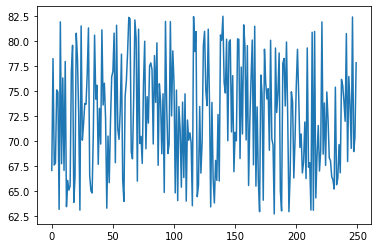

In [50]:
model.eval() 
perds = []
target = []
with torch.no_grad(): 
    correct = 0
    total = 0
    for data in valid_loader:
        images, labels = data['image'].to(device), data['label'].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        perds.extend(predicted)
        target.extend(labels)
        total += labels.size(0)
        # total = target.size(0)
        _,predicted = torch.max(outputs.data, 1)
        predicted = predicted.narrow(0,0,2)
        correct = (predicted == target)
    print('Test Accuracy of the model on the {} test images: {} %'
        .format(total, ((1 - (correct/total) ) * 100)))
    
plt.plot(Accuracies)

In [51]:
! pip install torchmetrics==0.10.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
from torchmetrics.functional import precision_recall
from torchmetrics import F1Score
from torchmetrics import ConfusionMatrix
perds1 = torch.stack(perds)
target1 = torch.stack(target)
target1 = target1[:,0]
# print(target1)

f1 = F1Score(num_classes=27).to(device)
print(f1(perds1.int(), target1.int()))
print(precision_recall(perds1.int(), target1.int(), average='macro', num_classes=27))
confmat = ConfusionMatrix(num_classes=27).to(device)
confmat(perds1.int(), target1.int())

tensor(0.2615, device='cuda:0')
(tensor(0.1945, device='cuda:0'), tensor(0.1115, device='cuda:0'))


tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  